In [ ]:
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import sqlite3
from functions.apriori_reccomender import apriori_reccomender
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

import matplotlib.pyplot as plt
import seaborn as sns

from functions.apriori_reccomender import apriori_reccomender


In [ ]:
def load_data(path):
    # Create a SQL connection to our SQLite database
    con = sqlite3.connect(path)

    df = pd.read_sql_query('SELECT * FROM beers', con)
    con.close()
    
    return df

def cluster_data(df, clusters=20, max_features=100, seed=42):
    # Step 1: Clean and Convert Numeric Columns
    df_nnn = df[["name", "abv", "review_text", "average_rating"]].drop_duplicates()
    df_nnn['abv'] = df_nnn['abv'].replace('-', np.nan).str.rstrip('%').astype(float)

    # Step 2: TF-IDF for Text Columns
    review_tfidf_vectorizer = TfidfVectorizer(max_features=max_features)
    review_tfidf = review_tfidf_vectorizer.fit_transform(df_nnn['review_text'].fillna('')).toarray()

    # Step 3: Standardize Numeric Columns
    scaler = StandardScaler()
    numeric_data = scaler.fit_transform(df_nnn[['abv']].fillna(0))

    # Step 4: Combine Preprocessed Data
    # Concatenate TF-IDF review features with standardized numeric data
    preprocessed_data = np.hstack([review_tfidf, numeric_data])

    # Step 5: Clustering with KMeans
    kmeans = KMeans(n_clusters=clusters, random_state=seed, n_init="auto")
    df_nnn['cluster'] = kmeans.fit_predict(preprocessed_data)

    # Include the "name" column in the returned DataFrame
    clustered_df = df_nnn[["name", "subgenre", "abv", "review_text", "cluster", "average_rating"]]

    return clustered_df, review_tfidf_vectorizer, scaler, kmeans

def predict_sample(df_sample, review_tfidf_vectorizer, scaler, kmeans):
    # Step 1: Preprocess Text Column
    new_review_tfidf = review_tfidf_vectorizer.transform(df_sample['review_text'].fillna('')).toarray()

    # Step 2: Preprocess Numeric Column
    new_numeric_data = scaler.transform(
        df_sample[['abv']].assign(
            abv=df_sample['abv'].str.rstrip('%').astype(float)
        )
    )

    # Step 3: Combine Preprocessed Data
    preprocessed_sample = np.hstack([new_review_tfidf, new_numeric_data])

    # Step 4: Predict Cluster
    predicted_cluster = kmeans.predict(preprocessed_sample)
    print(f"Predicted cluster for the new example: {predicted_cluster[0]}")

    return predicted_cluster[0]

def plot_genre_distribution_by_cluster(df, cluster_col='cluster', genre_col='subgenre', show_legend=True):
    # Group by cluster and genre to get counts
    genre_distribution = df.groupby([cluster_col, genre_col]).size().reset_index(name='count')
    
    # Plot the distribution
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=genre_distribution,
        x=cluster_col,
        y='count',
        hue=genre_col,
        dodge=True
    )
    
    plt.title("Genre Distribution Across Clusters")
    plt.xlabel("Cluster")
    plt.ylabel("Count")
    
    if show_legend:
        # Adjust the legend to be below the plot
        plt.legend(
            title=genre_col,
            bbox_to_anchor=(0.5, -0.3),  # Centered below the plot
            loc='upper center',
            ncol=5,  # Adjust the number of columns in the legend
            frameon=False  # Remove legend box border
        )
    else:
        # Turn off the legend
        plt.legend([], [], frameon=False)
    
    plt.tight_layout()  # Adjust layout to make space for the legend
    plt.show()


In [55]:

df = load_data("beer_data.db")

#beer_dict = apriori_reccomender(df, 0.005)

df, review_tfidf_vectorizer, scaler, kmeans = cluster_data(df, clusters=25, max_features=300)

# Get unique clusters for each beer
beer_clusters = df.groupby('name')['cluster'].unique().reset_index()
beer_clusters['cluster'] = beer_clusters['cluster'].apply(sorted)

display(beer_clusters[beer_clusters['name'] == "Nova Runda C4"])

example = {
    "abv": "2%",
    "review_text": "Coffee, dark, choclate and cherry",
}

df_sample = pd.DataFrame([example])

pred_cluster = predict_sample(df_sample, review_tfidf_vectorizer, scaler, kmeans)

# Beers in the predicted cluster
beers_in_pred_cluster = beer_clusters[beer_clusters['cluster'].apply(lambda x: pred_cluster in x)]['name'].values

# Filter and sort the top 10 beers in the predicted cluster by average_rating
top_beers = df.drop_duplicates('name')  # Ensure each beer is listed once
top_beers = top_beers[top_beers['name'].isin(beers_in_pred_cluster)]
top_beers = top_beers.sort_values('average_rating', ascending=False).head(10)  # Sort by average_rating

# Display relevant details
display(top_beers[['name', 'average_rating', 'abv']])


,name,cluster
1053,Nova Runda C4,"[0, 5, 12, 15, 17, 21]"


Predicted cluster for the new example: 1


,name,average_rating,abv
52465,The Garden Florida Weisse #02 (Pink Guava / Ly...,3.62,4.1
140514,Unorthodox BITTERSWEET LAMENT Malina + Limetka,3.60,3.5
187839,Gamma Suborbital,3.53,4.2
125272,Zmajska Pivovara Therapy Session IPA,3.53,3.9
140439,General Passionfruit Sour Flair 10°,3.51,4.0
139376,Donovalsky pivovar Summer Ale 10%,3.49,4.0
137732,Kláštorný ležiak tmavý 11°,3.49,4.2
173833,Mikkeller Hop On And Drink'in Berliner,3.49,2.8
173525,Warpigs Zawr Puß,3.47,4.6
140418,Unorthodox Point Of No Return,3.46,3.5


C:\Users\agent\AppData\Local\Temp\ipykernel_39544\31273745.py:87: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()  # Adjust layout to make space for the legend


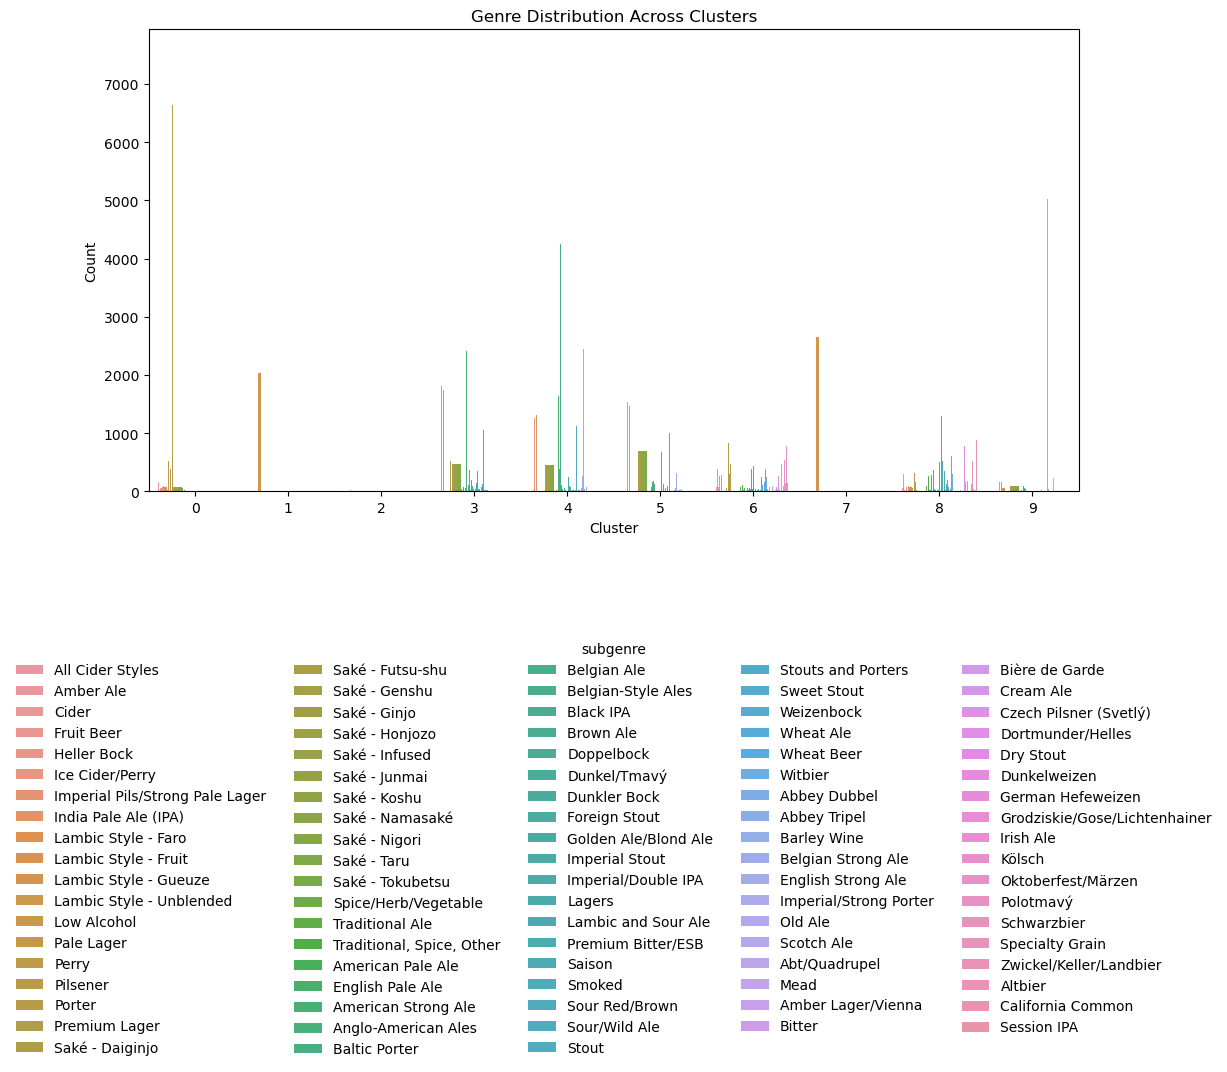

In [6]:
plot_genre_distribution_by_cluster(df, show_legend=True)